In [1]:
import sys

# 親ディレクトリのパスを直接追加
sys.path.append('/Users/ham/Desktop/LSHiforest')

import numpy as np
import pandas as pd
from JLSHiForest import JLSHiForest
from sklearn.metrics import accuracy_score

In [2]:
import pandas as pd
import numpy as np

# === ファイルパス指定（あなたの環境に合わせて変更してください） ===
features_path = "NUSW-NB15_features.csv"
data_path = "UNSW-NB15_1.csv"

# === データ読み込み ===
df_features = pd.read_csv(features_path, encoding='cp1252')
feature_names = df_features['Name'].tolist()

df = pd.read_csv(data_path, header=None, low_memory=False)
df.columns = feature_names

# データ数制限（最初の10000件を使う）
df = df.iloc[:100000, :]

# 正常データと異常データを分離
normal_data = df[df['Label'] == 0]
anomaly_data = df[df['Label'] == 1]

# カテゴリカル・数値特徴量の指定
categorical_features = [
    'sport', 'dsport', 'proto', 'service', 'state', 'is_sm_ips_ports', 'is_ftp_login'
]
numerical_features = [
    "dur", "sbytes", "dbytes", "sttl", "dttl", "sloss", "dloss", "Sload", "Dload", "Spkts", "Dpkts",
    "swin", "dwin", "stcpb", "dtcpb", "smeansz", "dmeansz", "trans_depth", "res_bdy_len",
    "Sjit", "Djit", "Sintpkt", "Dintpkt", "tcprtt", "synack", "ackdat", "ct_state_ttl",
    "ct_flw_http_mthd", "ct_ftp_cmd", "ct_srv_src", "ct_srv_dst", "ct_dst_ltm",
    "ct_src_ltm", "ct_src_dport_ltm", "ct_dst_sport_ltm", "ct_dst_src_ltm"
]

# 正常データを学習・テストに分割
train_size = 0.8
normal_train = normal_data.sample(frac=train_size, random_state=42)
normal_test = normal_data.drop(normal_train.index)

# === 数値特徴量のビニング関数 ===
def bin_numerical_features(df, numerical_features, n_bins=10):
    df_binned = df.copy()
    for col in numerical_features:
        unique_vals = df[col].nunique()
        if unique_vals > n_bins:
            df_binned[col] = pd.cut(df[col], bins=n_bins, labels=False)
        else:
            df_binned[col] = df[col]
    return df_binned

# トレーニング・テストデータをビニング適用
train_binned = bin_numerical_features(normal_train, numerical_features)
test_binned = bin_numerical_features(pd.concat([normal_test, anomaly_data]), numerical_features)

# 特徴量リスト（カテゴリカル＋ビニング後の数値特徴量）
features_to_use = categorical_features + numerical_features

# 最終データセット作成
X_train = train_binned[features_to_use]
y_train = normal_train['Label']  # すべて正常

X_test = test_binned[features_to_use]
y_test = pd.concat([normal_test, anomaly_data])['Label']

# データサイズ出力
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Train normal count: {y_train.value_counts().to_dict()}")
print(f"Test label distribution: {y_test.value_counts().to_dict()}")


X_train shape: (70856, 43)
X_test shape: (29144, 43)
Train normal count: {0: 70856}
Test label distribution: {0: 17714, 1: 11430}


In [3]:
# モデル訓練・評価
model = JLSHiForest(n_trees=100, max_depth=10, num_hashes=1, min_samples=10, random_state=42)
model.fit(X_train)
scores = model.decision_function(X_test)

universe size : 60619


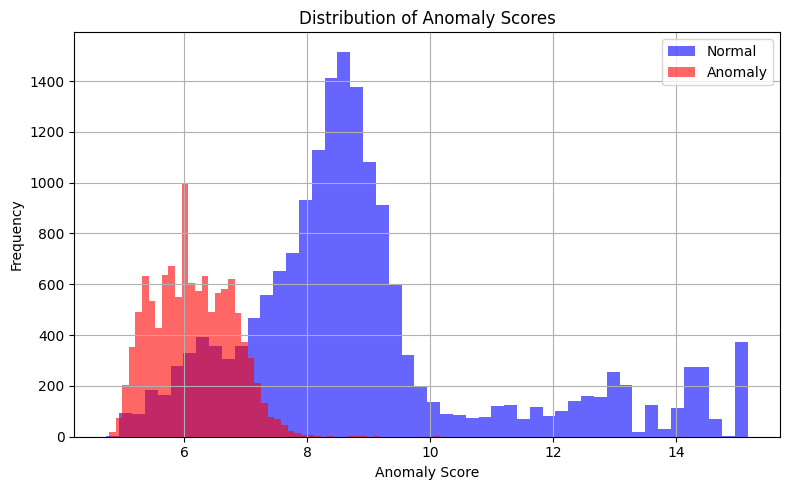

In [4]:
# 異常スコアの分布をプロット
model.plot_score_distribution(scores, y_test)

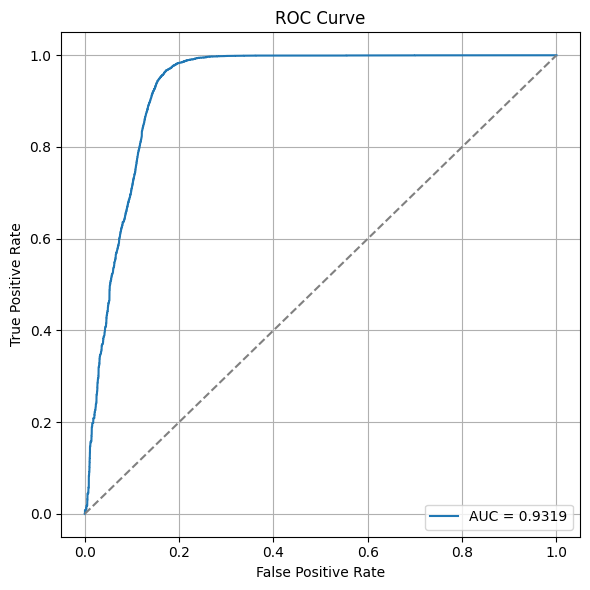

In [5]:
# AUC-ROCを計算
auc = model.plot_roc_curve(scores, y_test)

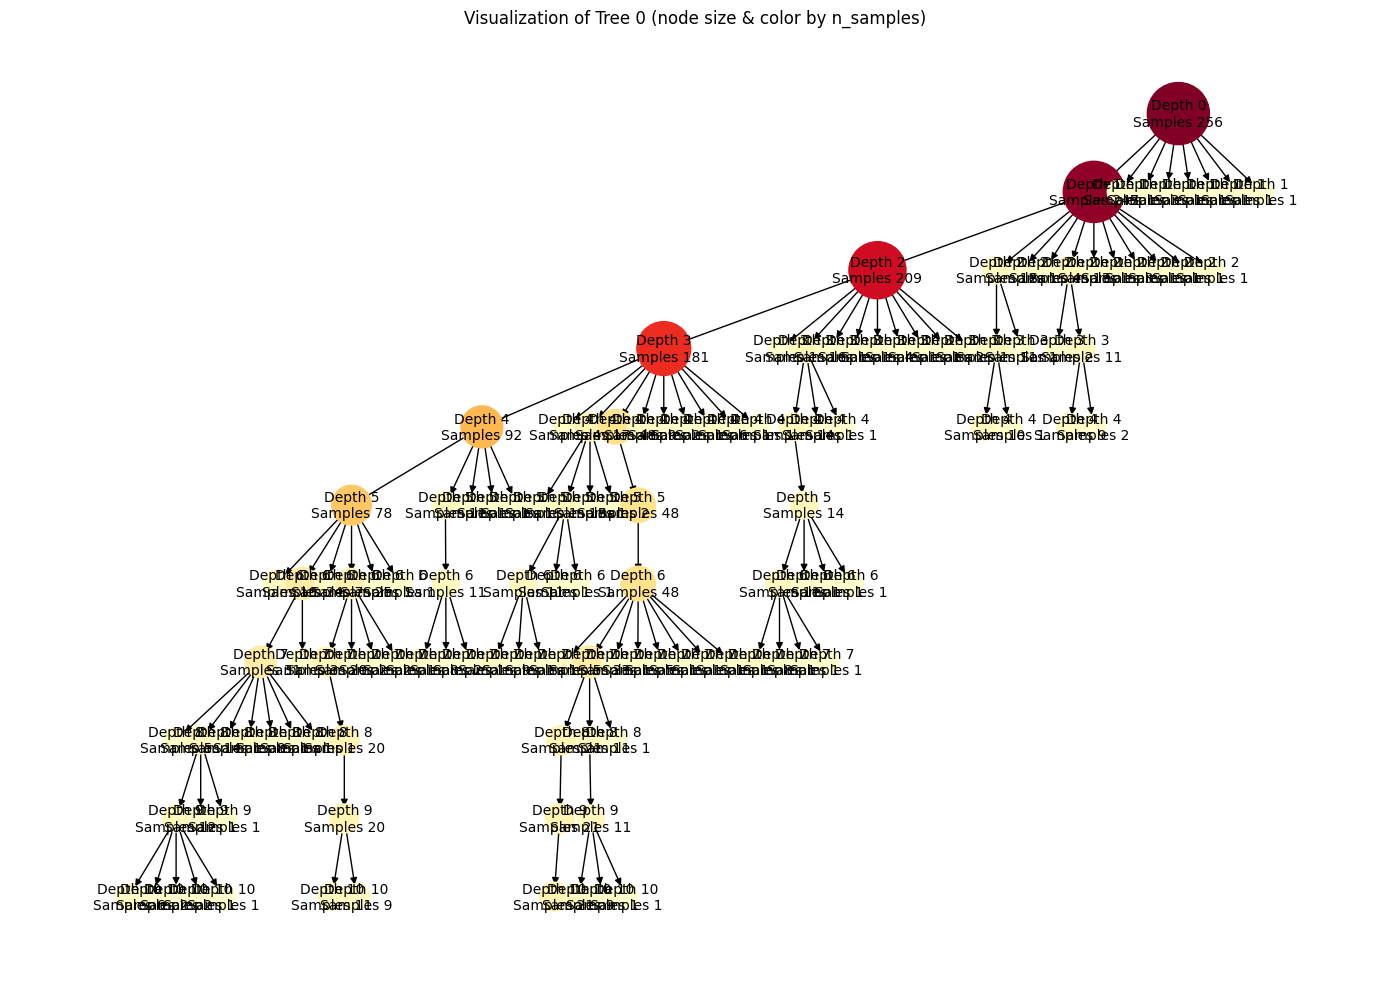

In [6]:
# 最初の木を可視化
model.visualize_tree(tree_index=0)